In [1]:
import numpy as np
import torch
from train_glm import train_glm
import matplotlib.pyplot as plt

# Train

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep10_stimseed1.npy"
C_syn_e_file = "handsub6_C_syn_e.npy"
C_syn_i_file = "handsub6_C_syn_i.npy"
C_den_file = "handsub6_C_den.npy"


E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
V = torch.from_numpy(V)
C_den = torch.from_numpy(C_den)

In [3]:
model_type = "alpha"
T_train = 60 * 1000 * 5
T_test = 10 * 1000 * 5
T_no = 500
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")
sparse_no = 4

if model_type == "alpha":
    batch_size = 100000
    iter_no = 20000
    epoch_no = 1
    lr = 0.001
elif model_type == "alpha_cos":
    batch_size = 2500
    iter_no = 10000
    epoch_no = 5
    #lr = 0.0007
    lr = 0.0025
elif model_type == "alpha_hist":
    batch_size = 4000
    iter_no = 7500
    epoch_no = 1
    lr = 0.0025
elif model_type == "gp":
    batch_size = 60000
    iter_no = 20000
    epoch_no = 5
    lr = 0.1
elif model_type == "gp_hist":
    batch_size = 4000
    iter_no = 10000
    epoch_no = 5
    lr = 0.0005
elif model_type == "alpha_gp_hist":
    batch_size = 4000
    iter_no = 10000
    epoch_no = 5
    lr = 0.0005

In [4]:
train_glm(model_type, V, E_neural, I_neural, T_train, T_test,
                T_no, batch_size, iter_no, epoch_no, C_den, C_syn_e, C_syn_i, 
                sparse_no, device, lr, save_dir)

61


0 -0.002713895059336391
50 0.018812813700208264
100 0.08511149892419978
150 0.22358414132363136
200 0.39976770609548984
250 0.5079498520316528
300 0.5422823572629776
350 0.5489371140021859
400 0.5547707318057251
450 0.5791953233427567
500 0.5929543662384513
550 0.6055265600139611
600 0.6142897311585892
650 0.6199956826248183
700 0.6263537180310665
750 0.6320029600680409
800 0.6384430356708827
850 0.6434185496599756
900 0.6490427446869181
950 0.6557818709040804
1000 0.6611511076164623
1050 0.6660847980808091
1100 0.6714800860708101
1150 0.6758599091332578
1200 0.68175440454852
1250 0.6867554856495857
1300 0.6908370698198243
1350 0.6952833717111851
1400 0.6992649144030508
1450 0.7043641606167488
1500 0.7086831833960787
1550 0.7124829268920234
1600 0.7168357362413176
1650 0.7205779631265171
1700 0.7243351958772222
1750 0.7283394873448606
1800 0.7330200557350113
1850 0.7364608940588485
1900 0.7391718115396626
1950 0.743120194852724
2000 0.7468677475605825
2050 0.7488652959589188
2100 0.753

16900 0.9122330767188253
16950 0.9120210067453983
17000 0.9117654621880851
17050 0.9118210902795213
17100 0.9120775889769364
17150 0.9119226795285813
17200 0.9118108322962015
17250 0.9118738813315449
17300 0.9118841125467003
17350 0.9117530173383017
17400 0.9122348281129578
17450 0.9121940548288628
17500 0.9121225235400683
17550 0.912143200889522
17600 0.912735492517412
17650 0.9123616192400175
17700 0.9120974752197322
17750 0.9124135797735561
17800 0.912654116936702
17850 0.9124679545174104
17900 0.9121926512733389
17950 0.9127401800605388
18000 0.9125913735893022
18050 0.9123516457017019
18100 0.9125132974495958
18150 0.9127303164556442
18200 0.9126861438626525
18250 0.9127633245945026
18300 0.9130158996888396
18350 0.9130516354858096
18400 0.9128867571605851
18450 0.912649828561782
18500 0.9129440766404301
18550 0.9126094385017577
18600 0.9130317079727576
18650 0.9128860679947182
18700 0.9130923619101424
18750 0.9129646140147568
18800 0.9130526125662187
18850 0.9131784449277031
1890

In [5]:
output = np.load("/media/hdd01/sklee/"+cell_type+"_"+experiment+"/"+model_type+"_sub6_output.npz")

In [6]:
test = output["test"]
C_syn_e = output["C_syn_e"]
C_syn_i = output["C_syn_i"]
filters = output["filters"]

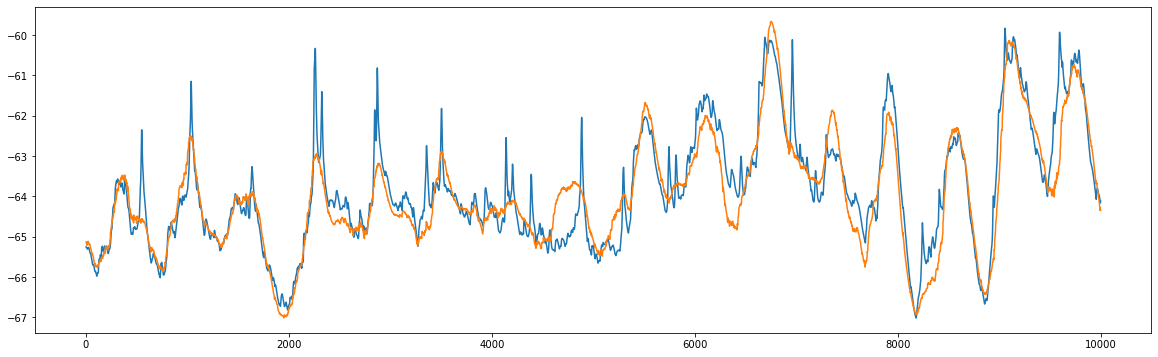

In [12]:
plt.figure(figsize = (20,6))
plt.plot(V[T_train:T_train+T_test][16000:26000][:])
plt.plot(test[16000:26000][:])


(12, 500)


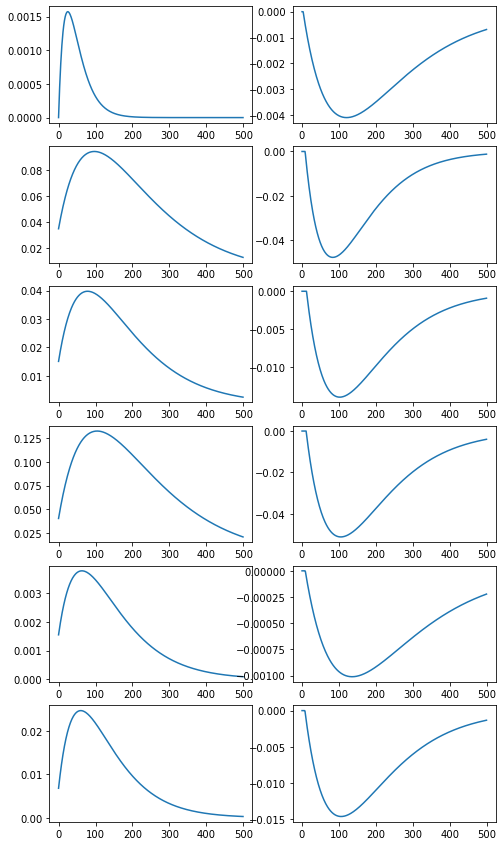

In [14]:
sub_no = 6
print(filters.shape)

fig, axs = plt.subplots(nrows=sub_no, ncols=2, figsize = (8,15))
for i in range(sub_no):
    axs[i,0].plot(filters[i])
    axs[i,1].plot(filters[sub_no+i])
    #axs[i,2].plot(filters[sub_no*2+i])